# Dusk Daylight

## Node decentralisation phase I


In [3]:
from matplotlib import pyplot as plt
import warnings
import scipy.stats as stats
import pandas as pd
import numpy as np

warnings.filterwarnings('ignore')


In [4]:
TARGET_BLOCKTIME_SECONDS = 10
EPOCH_SIZE = 2160
GENERATOR_BLOCK_REWARD = 14.4


## dusk.log

This notebook contains a breakdown of the logs generated by dusk-blockchain.
We are only interested in `run state transition` and `Accepted block from provisioner` messages.

To obtain stripped logs we executed command below and place the output in data folder:

    grep '"run state transition"\|"Accepted block from provisioner"' dusk.log > dusk_log_stripped.log


In [5]:
df_io = pd.read_json('data/dusk_log_stripped.log', lines=True)
df_io.drop(["event", "cert_step", "curr_h", "level",
           "process", "msg"], inplace=True, axis=1)


In [6]:
# Combine the state transition and block acceptance messages into single line per blockheight.
df = df_io.groupby('height').first()
# Convert the time collumn to pandas datetime datatype
df['time'] = pd.to_datetime(df.time, format="%Y-%m-%dT%H:%M:%S%z")


In [7]:
# Add corresponding EPOCH to dataframe
epochs_bin = np.arange(1, df.index.max()+EPOCH_SIZE, EPOCH_SIZE)
epochs_labels = np.arange(1, len(epochs_bin), 1)
df['epoch'] = pd.cut(df.index, bins=epochs_bin,
                     right=False, labels=epochs_labels)


In [8]:
# Check first and last two rows of our dataframe to see what we are working with
df.iloc[np.r_[0:2, -2:0]]

,block_time,e_prov,hash,prov,time,txs_count,generator,iteration,epoch
height,,,,,,,,,
1,21754909.0,5.0,0d0acaf76f...0468e2752b,5.0,2022-11-18 16:34:57+01:00,0.0,uZvKUYkVz7SJkicS4gQXGAjj8rziVkcV7ZXqGJAKNSW7iF...,3.0,1
2,4.0,5.0,876e3bafc3...ca6034634e,5.0,2022-11-18 16:34:57+01:00,0.0,23RRcwBV2BsBVvmNPUh16xCYfLZj7qkxjCFg8dS5hkJcRr...,1.0,1
242785,37.0,491.0,cb886d0505...9f157e908a,493.0,2023-01-06 14:32:02+01:00,0.0,rm6jwcM9xQChnVeHYw6W8HP7kW3E8nejgs4XhmKoYspQnr...,2.0,113
242786,26.0,491.0,d61373dd0d...9fbff6e9b1,493.0,2023-01-06 14:32:12+01:00,0.0,xxRf7HtmFrcNqF8QpEpXmNqEePC7ftcrAGyavJQUv5mQrZ...,1.0,113


## Node synchronization

Node was synched within 6 hours. First hours were faster. Last 3 hours it was synching at steady rate around 40 blocks per minute.


First block was ingested in the node at 16:34:57.
Node was fully synchronized with the rest of the network at 22:15:33 or around blockheight 31305.

=> Synching 31305 blocks took ~340 minutes. <br>
=> Overall sync speed ~92 blocks per minute.


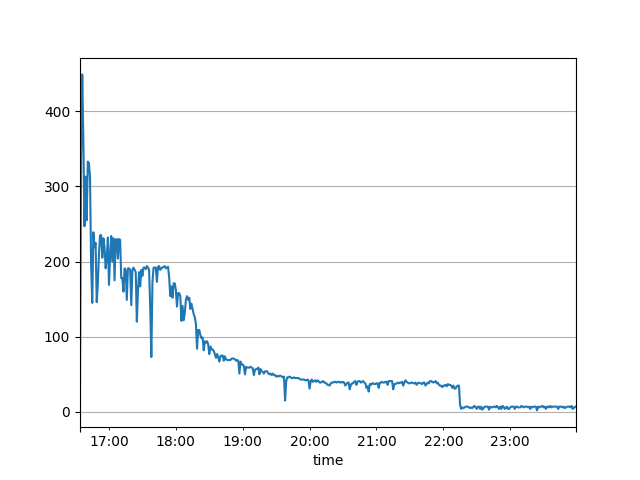

In [9]:
%matplotlib widget
df[df.time.dt.strftime('%Y-%m-%d') == '2022-11-18'].groupby(pd.Grouper(key='time', freq='min')).size().plot().grid()

In [10]:
# As soon as sync delta is near 0 it signals a high probability the sync is finished. Blocks are now detected at same speed as recorded by network.
df_sync = df[['block_time', 'time']].loc[(df.index < 5) | (df.time.dt.strftime('%Y-%m-%d %H %M') == '2022-11-18 22 15')]
df_sync['_sync_time']=(df['time']-df['time'].shift()).dt.seconds.fillna(0).astype(int)
df_sync['_sync network Δ'] = (df_sync['_sync_time']-df_sync['block_time'])
df_sync


,block_time,time,_sync_time,_sync network Δ
height,,,,
1,21754909.0,2022-11-18 16:34:57+01:00,0,-21754909.0
2,4.0,2022-11-18 16:34:57+01:00,0,-4.0
3,4.0,2022-11-18 16:34:57+01:00,0,-4.0
4,3.0,2022-11-18 16:34:57+01:00,0,-3.0
31300,10.0,2022-11-18 22:15:01+01:00,2,-8.0
31301,8.0,2022-11-18 22:15:03+01:00,2,-6.0
31302,7.0,2022-11-18 22:15:05+01:00,2,-5.0
31303,10.0,2022-11-18 22:15:07+01:00,2,-8.0
31304,30.0,2022-11-18 22:15:24+01:00,17,-13.0


In [11]:
SYNC_COMPLETE_HEIGHT = 31305

## Block times

Over the period of testphase we see the network took more and more time on average to produce a block. Looking at the median blocktime per epoch we float around the target 10s with a slow drift upwards. 

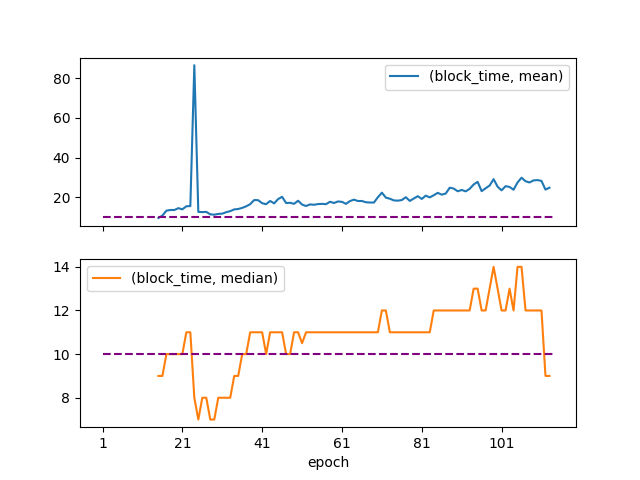

In [21]:
%matplotlib widget
plot = df[SYNC_COMPLETE_HEIGHT:].groupby("epoch").agg(['mean','median']).plot.line(y=["block_time"], subplots=True)
plot[0].hlines(y=TARGET_BLOCKTIME_SECONDS, xmin=0, xmax=113, linestyles='--', color='purple')
plot[1].hlines(y=TARGET_BLOCKTIME_SECONDS, xmin=0, xmax=113, linestyles='--', color='purple')

Looking at the distribution of blocktimes we find a repeating pattern. Most blocks were produced within 20 seconds. Note there is a remarkable peak at the end. The max blocktime is 360 seconds. I'm not sure what the network does when it hits that timeout. Anyway. It was hit very often.

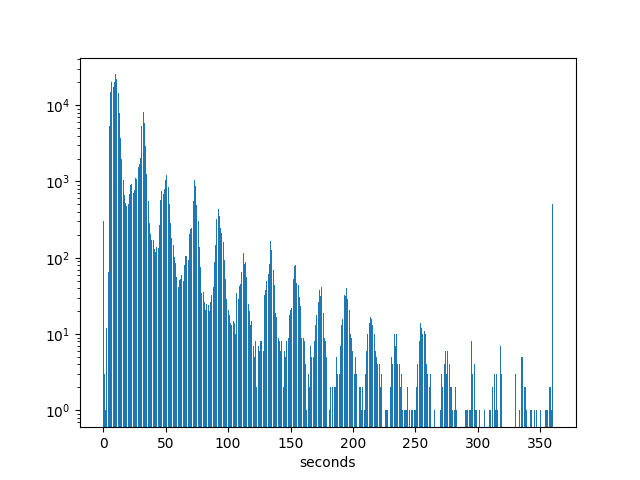

In [22]:
%matplotlib widget
btimes = df[SYNC_COMPLETE_HEIGHT:].groupby('block_time').size()
fig, ax = plt.subplots()
bars = ax.bar(btimes.index, btimes.values)
ax.set_yscale("log")
ax.set_xlabel("seconds")
plt.show()


In [ ]:
%matplotlib widget
bins = pd.cut(df[SYNC_COMPLETE_HEIGHT:]['block_time'], np.arange(0, 360, 25))
btimes = df[SYNC_COMPLETE_HEIGHT:].groupby(bins)['block_time'].count().plot(kind='bar', rot=45).set_yscale('log')


In almost every epoch there were blocks with very high blocktimes. Often blocks that hit the limit of 360 seconds.

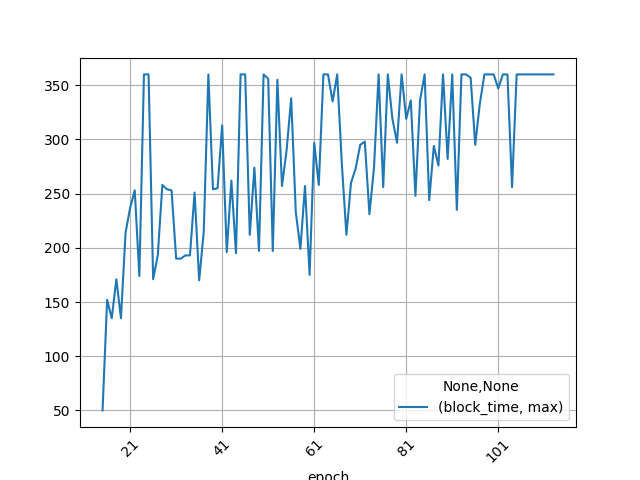

In [24]:
#Highest blocktime per epoch
%matplotlib widget
df[SYNC_COMPLETE_HEIGHT:].groupby('epoch').agg(["max"]).plot.line(y=["block_time"], rot=45, subplots=False).grid()


If it takes longer to produce a block. It means less blocks per hour are added to the network.

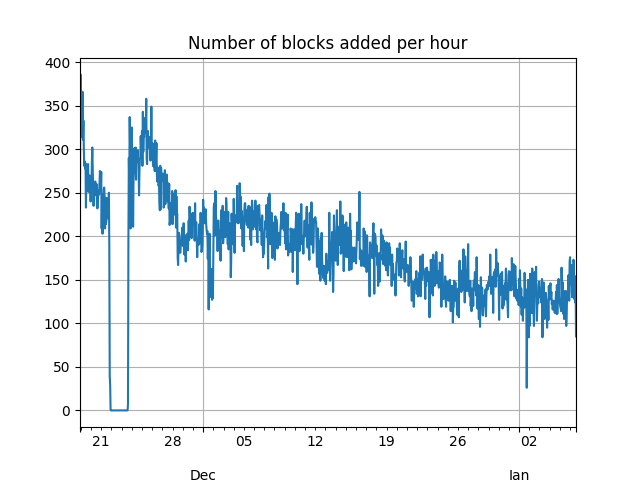

In [25]:
#Blocks per hour after complete synchronisation
%matplotlib widget
df[SYNC_COMPLETE_HEIGHT:].groupby(pd.Grouper(key='time', freq='H', axis=0)).size().plot(title="Number of blocks added per hour").grid()


## Transactions
We got up to 10 transactions in a single block. In total there were 4 blocks that had 10 transactions in it. 29 blocks had 9 transactions. 234756 blocks were empty.

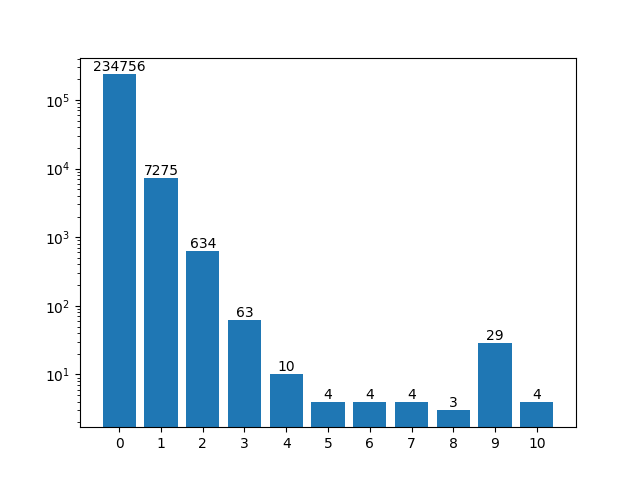

In [26]:
%matplotlib widget
txs = df.groupby('txs_count').size()
fig, ax = plt.subplots()
bars = ax.bar(txs.index[0:11], txs.values[0:11])
ax.bar_label(bars)
ax.set_xticks(txs.index)
ax.set_yscale('log')
#ax.get_xaxis().set_visible(False)
#ax.invert_yaxis()
plt.show()



Most transaction activity was occuring during the stake distribution period.

array([<AxesSubplot:xlabel='epoch'>, <AxesSubplot:xlabel='epoch'>],
      dtype=object)

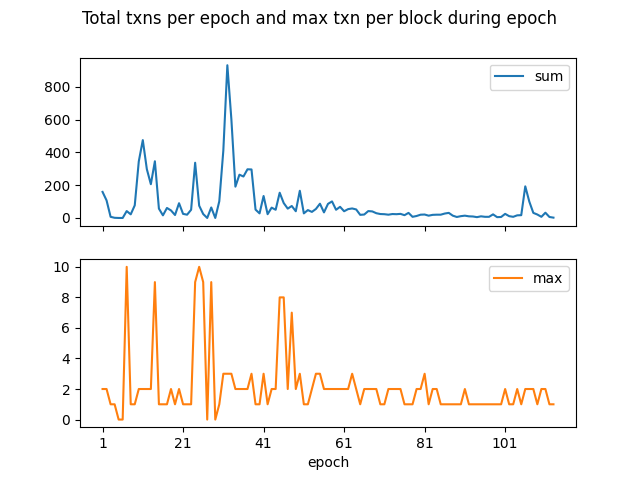

In [27]:
%matplotlib widget
df.groupby('epoch').agg('txs_count').agg(['sum','max']).plot(subplots=True, title="Total txns per epoch and max txn per block during epoch")

## Consensus

## Provisioners and generators


Provisioners join the network.

You can visualy see the stake maturisation period. During onboarding periods you see there is more provisioner than eligible provisioners. For each new staked provisioner it takes 2 epochs to become elegible.

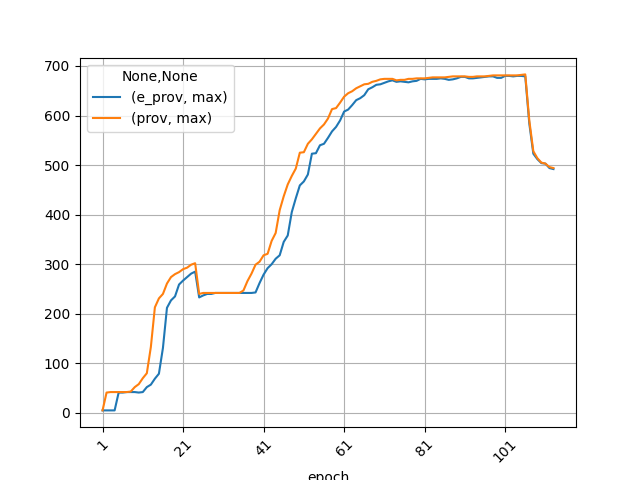

In [30]:
# Provisioners
%matplotlib widget
df[1:].groupby('epoch').agg(['max']).plot.line(
    y=["e_prov", 'prov'], rot=45).grid()

Top 20 generators

In [52]:
generators = df['generator'].value_counts()
generators[0:20].rename("count blocks produced").to_frame()

,count blocks produced
y8npeVCvV4nxZYsYo4cBFkkiLU7JWfxzG71HvL6v4sku8GKz1tVn4PWFjEUyMRFUDLT1Sz5p6V94PWJacgWNNXg8CdknJjeDgpuDeGnSovGr4Kq4oVw4ags8fjVgWgu1Qm1,30603
u3KJA2AJywE5sBR8HJ79GZ9i8r5z4j2q2wPoL6LwzaCKDpXNHBCSM2SjS3uRzojz8arnYPgmjfeQojENNUcfjvv9onZeDrSh4oeiLGFverUrMGoJewZqE8aRbsu4DhLeiPK,19535
m7pqtJupkjXmHrMWx5229nWGm4RTebHCqt7qxScrUnvMVJUUwQziyUFosrMzfafBbwEDoFhky8qrVTjpVR2UWwc5xYwh11F9fMLk2ksWTinA6P3rNjXWJP1nzThdvuycrju,12363
mxZPa2SSrt6tcQ6D62GgAGhQxCtMptZGZsK1PDR642PDQPmyLb4RQDVj3jFKJifYdv1R75WsMcKy2xRkJ58QSTUvaKs5Nsy9quzd5gAWQDSQuqaEin6zqcd1BBSaFoA76bc,6523
23RRcwBV2BsBVvmNPUh16xCYfLZj7qkxjCFg8dS5hkJcRrnVbFr5sHHGvTYbcvyDaZ19D6jqn21miC52y9rjycYrG1EBtc1wYwZLhZLHk63L52aaYYoyJtgM6hbuzmPXVvaQ,4520
uZvKUYkVz7SJkicS4gQXGAjj8rziVkcV7ZXqGJAKNSW7iFFfTYCdo3k9Hw4A5dPfUxvBDtBPiSDjmehZGEQwDSYkdSf39WDEbavq9XHyzLY1S72EXCbEoB38avxaY7eXp6i,4494
xxRf7HtmFrcNqF8QpEpXmNqEePC7ftcrAGyavJQUv5mQrZKmS1GBazS1fbrftFbj5t6A19F4FComuyLcS9dVkgu8bE7vzA4QTfEUWWjLU9As9FaazE8ewVEBkAe4f8SeGny,4479
rm6jwcM9xQChnVeHYw6W8HP7kW3E8nejgs4XhmKoYspQnrZL5dDcQjVR5e2UmbyNNF4DJDRdZGdYLgJfZ3qQXuhSCL6UTDkcQ2QEf6RW3aCtfqQMKCFMNaBsfNrZuzrP23Z,3966
uazLgN2HtLqaDZCxAtJtkkurQTXyZWXjQYJ3HdSVbpBjGRzMvKaqvpx3MRw8HTv7bTwyviLosEJAa56G66cdNjL4CJdqTUyFHdufzWWfLz9E7eF97tdc6jZsVTiGXGNGf2E,3441
tMdC8q1K7mzXPcR9NMLqxm2Ug3JHAk4s5LTHtci7fF18SCjqhFJsDXUQyPuprPMzZqH4DK5ZE1Z3FrX4aMHRYz8RJp8KzJvqNai5i35S53ZMzanMn39dfgFSZPmRK6jHetN,3174


Below a visualisation of generators ranking by produced blocks. Each dot is a generator (X-ax). On Y-ax we applied a trick to see the distance between the amount of blocks a generator produced. Highest earning generators are very distictive at the top.

We recognize 4 plateaus. The highest are most likely the team nodes. Second level are early node participants who received 30k testnet Dusk.

After team made adjustments to testnet distribution, participants received around 1100 testnet dusk tokens. Those are most likely the nodes near the bottom. At the most right, the lower rank, are most probably the nodes that have staked the minimun required stake of 1000 dusk.

For a moving animation over time, check the video generators_rank_evolution.mp4 in the repository.

<AxesSubplot:>

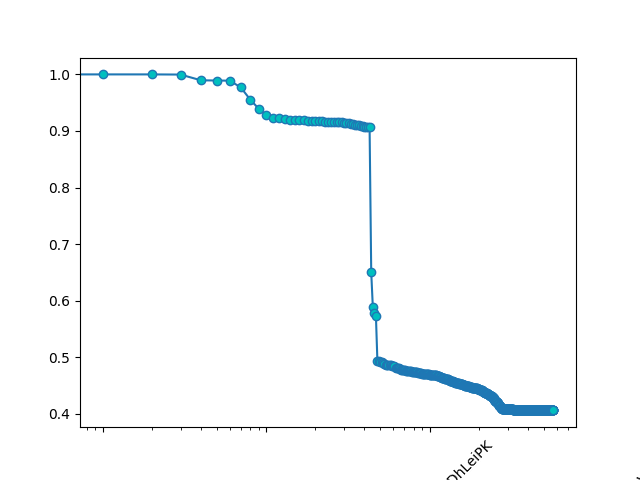

In [51]:
%matplotlib widget
generators = df['generator'][df['epoch'] <= 113 ].value_counts()
mean = generators.mean()
std = generators.std()
cdf = stats.norm.cdf(generators, mean, std)
generators_df = generators.to_frame()
generators_df['cdf'] = cdf
generators_df['cdf'].plot.line( logx=True, style='.-', marker='o',markerfacecolor='c', rot=45)
